###  Novilhos Crioulos e Mestiços: Ganho de Peso, Pastejo, Qualidade de Carcaça

<p>As vacas Rarámuri Criollo têm características comportamentais que são desejáveis ​​para pastagens em ambientes áridos, mas os bezerros deste biótipo são difíceis de comercializar através de métodos convencionais. Uma estratégia para melhorar a comercialização é cruzar essas vacas com touros tradicionais de corte. No entanto, não está claro se os bezerros mestiços atingirão pesos comercializáveis ​​e qualidades de carcaça em pastagens e se manterão os comportamentos de pastejo desejáveis ​​de suas mães. Vamos analisar essa base de dados e encontrar respostas. <br>

Fonte de dados: [Data.gov](https://catalog.data.gov/dataset/criollo-and-crossbred-steer-comparison-weight-gain-grazing-carcass-quality-2015-2017-f1052)</p>

In [1]:
import pandas as pd
import seaborn as sns


# Dataset - Peso_do_Gado
path = r"C:\Users\julio\Desktop\intergado\DB\.ipynb_checkpoints\pesos_do_gado.csv"
cattleweight = pd.read_csv(path, encoding="utf-8", sep=",")

# Dataset - NDVI (Índice De Vegetação Por Diferença Normalizada)
'''
NDVI (https://geografiadascoisas.com.br/artigos/tudo-o-que-voce-precisa-saber-sobre-o-ndvi-parte-1/)
JulianDate (JD)
desvios padrão (SD)
erro padrão (SE)
'''
path = r"C:\Users\julio\Desktop\intergado\DB\.ipynb_checkpoints\NDVI.xlsx"
NVDI = pd.read_excel(path)

In [2]:
cattleweight.head()

,date,breed,cohort,cow_id,weight
0,12/4/2015,RC,C1,4024,268.980056
1,12/4/2015,RC,C1,4096,235.187452
2,12/4/2015,RC,C1,4095,284.402184
3,12/4/2015,RC,C1,4057,331.802548
4,12/4/2015,RC,C1,4009,274.196364


In [3]:
NVDI.head()

,year,julian date,date,NDVI mean,max,min,sd,se
0,2015,337,2015-12-03,0.07,0.20,-0.15,0.06,0.002203
1,2015,353,2015-12-19,0.11,0.22,-0.08,0.06,0.002203
2,2016,1,2016-01-01,0.09,0.22,-0.09,0.05,0.001836
3,2016,17,2016-01-17,0.11,0.23,-0.06,0.05,0.001836
4,2016,33,2016-02-02,0.14,0.25,-0.05,0.05,0.001836


### Enriquecendo o banco de registro.


<p>A pecuária de precisão está transformando o setor, mas ainda é uma tarefa dificil acompanhar o registro diario do desenvolvimento bolvino. Por esse motivo temos dados que não fornecem um acompanhamento preciso da fase de engorda, então para enriquecer esses dados faltantes,  as lacunas temporais foram preenchidas com o calculo de interpolação entre os pesos que foram registrados. <br> 

A empresa brasileira [intergado](https://pecuariadealtaperformance.com.br/intergado/pt/home/) fornece diariamente o peso de cada animal, mostrando a evolução em números e traçando a curva de ganho de peso diário. Estas informações permitem ao produtor o acompanhamento individual do comportamento dos animais em todas as fases da engorda, vale a pena conhecer o modelo de extração elaborado por eles.</p>

In [4]:
# Exemplo de lacunas temporais
cattleweight[cattleweight.cow_id == 4024]

,date,breed,cohort,cow_id,weight
0,12/4/2015,RC,C1,4024,268.980056
10,2/24/2016,RC,C1,4024,280.319856
20,5/4/2016,RC,C1,4024,282.36102
30,7/20/2016,RC,C1,4024,343.59594
40,10/4/2016,RC,C1,4024,360.60564


#### Iniciando o tratamento

In [5]:
# Ignore Warning Setting With Copy
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


cattleweight = cattleweight[~cattleweight['weight'].isin(['#VALUE!'])]

# insert model
dfCattle = cattleweight.iloc[[1]]
dfCattle['date'] = pd.to_datetime(dfCattle['date'])
dfCattle['weight'] = dfCattle['weight'].astype(float)

In [6]:
'''
Documentação: 

A função gado permite que o tratamento de interpolação de valores faltantes seja feito em cada ID 
registrado no dataset original. Essa função ainda não passou por testes de problemas que possam ser vinculados a outro
dataset. 
'''


def gado(id_gado):
    
    global dfCattle
    
# filter id
    df = cattleweight[cattleweight['cow_id'] == id_gado]
    
# missing date, transform index 
    df.index = pd.DatetimeIndex(df['date']).floor('D')
    all_days = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df = df.reindex(all_days) 
    
# missing date, index to column
    df = df.drop(['date'], axis=1).reset_index()
    df.rename(columns={'index':'date'}, inplace=True)
    df['date'] = df['date'] 
    
# calculate interpolation, replace missing values in date
# reference (https://towardsdatascience.com/how-to-fill-missing-data-with-pandas-8cb875362a0d)
    df['weight'] = df['weight'].astype(float).interpolate(method = 'linear')
    
#   missing [breed - cohort - cow_id]
#   [values]
    RC = df['breed'].dropna().unique()[0]
    cohort = df['cohort'].dropna().unique()[0]
    cow_id = df['cow_id'].dropna().unique()[0]

#   [apply values]   
    df['breed'].fillna(value = RC, inplace = True)
    df['cohort'].fillna(value = cohort, inplace = True)
    df['cow_id'].fillna(value = cow_id, inplace = True)
    df['cow_id'] = df['cow_id'].astype(int) # convert type
    
    dfCattle = pd.merge(df, dfCattle, how = 'outer')

In [7]:
# Chamando a função gado
cattleweight['cow_id'].apply(lambda ID: gado(ID))

0      None
1      None
2      None
3      None
4      None
       ... 
288    None
289    None
290    None
291    None
292    None
Name: cow_id, Length: 289, dtype: object

In [8]:
# Fragmentando as datas por coluna Ano - Mes - Dia
dfCattle['year'] = dfCattle['date'].dt.year
dfCattle['month'] = dfCattle['date'].dt.month_name()
dfCattle['day'] = dfCattle['date'].dt.day

In [20]:
dfCattle.weight.max() / 15

29.241564266666668

In [24]:
# Ignore Warning Setting With Copy
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Convertendo Arroba
dfCattle['arroba'] = (dfCattle.weight / 15)
dfCattle['arroba'] = pd.cut(x=dfCattle['arroba'], bins=[0, 12, 16, 20, 23, 26, 30],
                    labels=['0-11', '12-15', '16-19',
                            '20-22', '23-25', '26-30'])

dfCattle.dropna(subset=['arroba'], inplace=True)

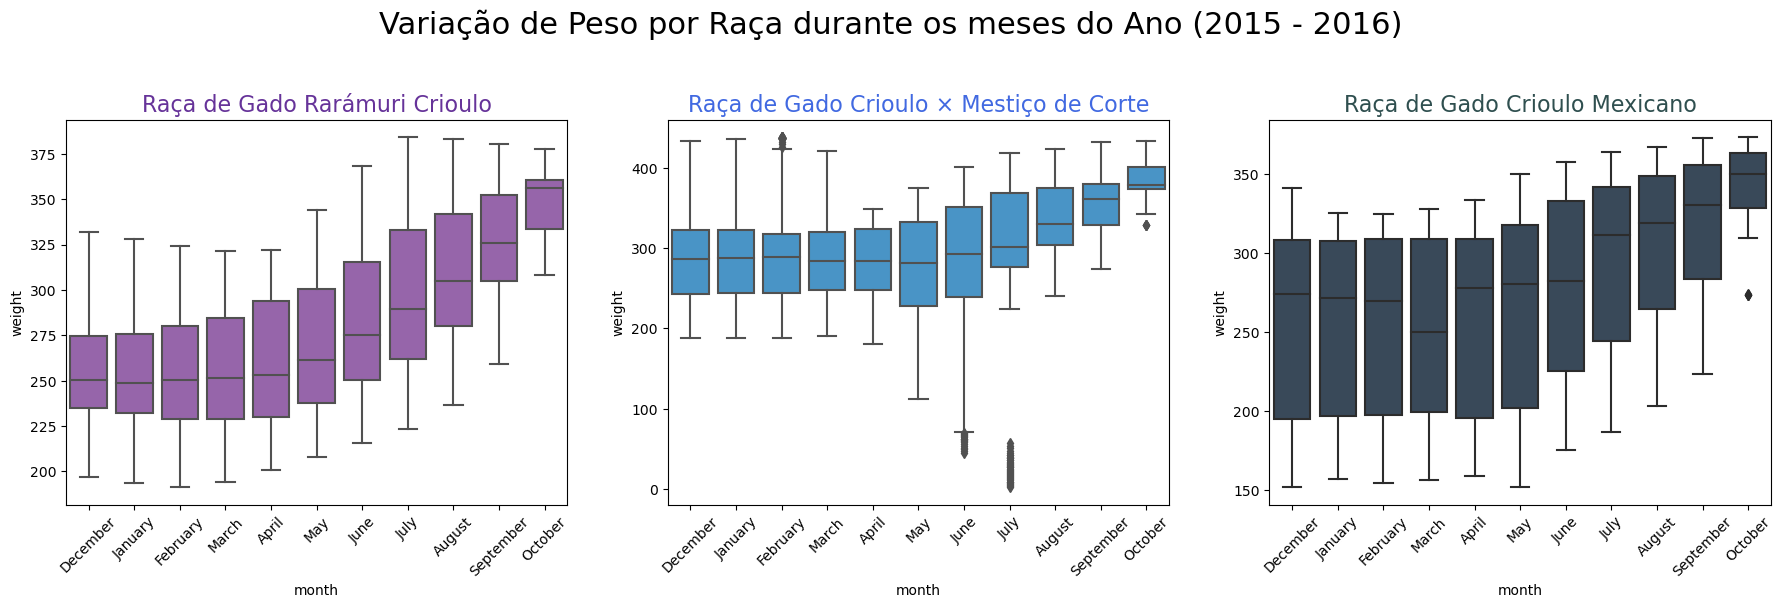

In [26]:
import matplotlib.pyplot as plt
import numpy as np
 
 
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
 
fig.suptitle('Variação de Peso por Raça durante os meses do Ano (2015 - 2016)', fontsize=22, y=1.10)
 
RC = dfCattle[dfCattle['breed'] == 'RC']
XC = dfCattle[dfCattle['breed'] == 'XC']
MC = dfCattle[dfCattle['breed'] == 'MC']
 
# Plots    
sns.boxplot(ax=axes[0], data=RC, x='month', y='weight', color='#9b59b6')
axes[0].set_title('Raça de Gado Rarámuri Crioulo', fontsize=16, color='rebeccapurple')
axes[0].tick_params('x', labelrotation=45)

sns.boxplot(ax=axes[1], data=XC, x='month', y='weight', color='#3498db')
axes[1].set_title('Raça de Gado Crioulo × Mestiço de Corte', fontsize=16, color='royalblue')
axes[1].tick_params('x', labelrotation=45)

sns.boxplot(ax=axes[2], data=MC, x='month', y='weight', color='#34495e')
axes[2].set_title('Raça de Gado Crioulo Mexicano', fontsize=16, color='darkslategray')
axes[2].tick_params('x', labelrotation=45)

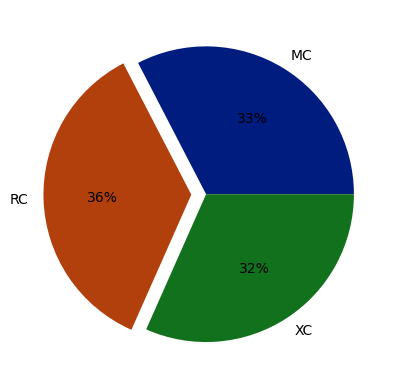

In [27]:
cattleBreed = pd.DataFrame(dfCattle.groupby("breed")["breed"].count()).rename(columns={'breed':'qtd'}).reset_index()

# declaring data
data = cattleBreed['qtd'].values
keys = cattleBreed['breed'].values
  
# declaring exploding pie
explode = [0, 0.1, 0]
# define Seaborn color palette to use
palette_color = sns.color_palette('dark')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')
  
# displaying chart
plt.show()

1. Análise de por raça<br>
    1.1 [Raça Rarámuri Crioulo](#pA)<br>
    1.2 [Raça Crioulo x Mestiço de Corte](#pB)<br>
    1.3 [Raça Crioulo Mexicano](#pC)<br>

In [28]:
dfCattle.to_csv('CattleWeight.csv', index=False)